# **Classification and Detection of Disaster Tweets**
---

Natural Disasters have caused an average of 60,000 deaths worldwide. When Natural Disaster strike, many that have witnessed it would often report it on social media in real time which can be done through twitter or facebook. Many often seek news from social media as it is much faster than traditional media. Since people would report it on social media, there is a need for fast response from the rescue operators to respond to the disaster. However, there is currently no system in place to alert the rescue operators about a disaster that is posted on social media.

The goal of this project is to identify tweets that are deemed as a `Disaster Tweet` through the use of Machine Learning

In order to achieve the goals set out, we will need to:
* Find a suitable dataset
* Clean the dataset
* Find a suitable model for training
* Implement the idea

## Prerequisite
---

### Import Libraries for project
---

Before we begin, we will import the following libraries:
> `numpy` - Array for data manipulation  
> `pandas` - Data manipulation for source  
> `seaborn`, `mathplotlib` -  Data visualization library  
> `wordcloud` -  Wordcloud visualization  
> `sklearn` -  Used to split train and test data  
> `tensorflow` - Machine Learning library  
> `re` -  Regular expression for cleaning data  
> `string` - Finding out all punctuations for cleaning data  

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
import re
import string
import nltk
from nltk.tokenize import RegexpTokenizer
import collections

### Import Dataset from CSV File
---

Dataset by [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data).  
Since it is formatted into a CSV file, we can import the dataset into Python through `read_csv()` function.  
`head()` function is used to verify that the dataset is successfully imported.

In [ ]:
fileURL = "https://raw.githubusercontent.com/woonyee28/mini-project/main/train.csv" #Assign link of dataset to variable
original_tweets = pd.read_csv(fileURL) #Import data into original_tweets

In [ ]:
#original_tweets = pd.read_csv("/content/Dataset/mini_project_train.csv") #Import data from CSV File
original_tweets.head() #Verify that data is imported

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Count number of dataset for each category
---

The dataset `original_tweets` has a column named `target` that stores values `0`, and `1`.

The value represents whether data in the row is classified as Disaster Text, where `1` represents **Disaster Text**, and `0` represents **Non-Disaster Text**.

We will change the column name to `isDisaster` to make it clearer, then count the number of dataset in each category of `isDisaster`

In [ ]:
original_tweets.rename(columns={'target': 'isDisaster'},inplace=True) #Rename the column 'label' to 'isDisaster'
original_tweets.groupby('isDisaster').count() #Group based on the category, and count the number of entries for each category

,id,keyword,location,text
isDisaster,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


Number of tweets classified as **Disaster Speech**: **3,271**  
Number of tweets classified as **Non-Disaster Speech**: **4,342**  

The dataset has a disproportionate number of Disaster Speech to Non-Disaster Speech. We will need to balance the dataset. We will be doing that in the **Imbalanced Dataset** section

## Data Cleaning
---

The data we chose contains special characters which would not work with tensorflow. We will need to clean up all unnecessary characters before continuing. 

### Data Cleaning Functions
---

To use the data, we will need to clean up any unnecessary characters that may cause issues:
> `remove_user()` - Removes `@user` found in tweets. Removing the `@user` would increase the accuracy of the result. Else, it will show up in the wordcould for both Disaster Text and Non-Disaster Text.  
> `remove_URL()` - Removes URLs found in tweets.   
> `remove_HTML()` - Removes HTML tags if any.  
> `replace_HTML_reserve()` - Replaces HTML reserve characters such as `&lt;`, `&gt;`, `&amp;` into its original form `<`, `>`, `&`.  
> `remove_emoji()` - Removes any emojis in tweets.  
> `decontraction()` - Replaces contractions like `let's` into its orignal form `let us`.    
> `remove_non_alphanumspace()` - Removes weird charactesr such as `Â` and `ð`, any punctuations, and special characters.  
> `seperate_alphanumeric()` - Separates words like `gr8` into `gr 8` for data processing later on.  
> `cont_rep_char()` - Replaces 3 or more repeated character without any space to 2 repeated character. e.g., `eee` to `ee`  
> `unique_char()` - Find repeated characters and pass it to `cont_rep_char()` function, then replaces the said character.  
> `remove_all()` - Takes in parameters `(dataset, column)` and execute the above functions on the given column in the dataset.

In [ ]:
def remove_user(text):
    user = re.compile(r'@user')
    return user.sub(r'', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'', text)

def replace_HTML_reserve(text):
    text = re.sub(r"&amp;", "&", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&le;", "<=", text)
    text = re.sub(r"&ge;", ">=", text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"(\S)\'re", r"\1 are", text)
    text = re.sub(r"(\S)\'s", r"\1 is", text)
    text = re.sub(r"(\S)\'d", r"\1 would", text)
    text = re.sub(r"(\S)\'d've", r"\1 would have", text)
    text = re.sub(r"(\S)\'ll", r"\1 will", text)
    text = re.sub(r"(\S)\'ll've", r"\1 will have", text)
    text = re.sub(r"(\S)\'t", r"\1 not", text)
    text = re.sub(r"(\S)\'ve", r"\1 have", text)
    text = re.sub(r"(\S)\'m", r"\1 am", text)
    text = re.sub(r"(\S)\'re", r"\1 are", text)
    return text 
    
"""
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
"""

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'([A-Za-z])\1+', rep, text)
    return substitute

def remove_non_alphanumspace(text):
    url = re.compile(r'[^0-9a-zA-Z\s]+')
    return url.sub(r'', text)

def remove_all(dataset, column):
    dataset[column] = dataset[column].apply(lambda x : remove_user(x))
    dataset[column] = dataset[column].apply(lambda x : remove_URL(x))
    dataset[column] = dataset[column].apply(lambda x : remove_HTML(x))
    dataset[column] = dataset[column].apply(lambda x : replace_HTML_reserve(x))
    dataset[column] = dataset[column].apply(lambda x: remove_emoji(x))
    dataset[column] = dataset[column].apply(lambda x : decontraction(x))
    dataset[column] = dataset[column].apply(lambda x : remove_non_alphanumspace(x))
    dataset[column] = dataset[column].apply(lambda x : seperate_alphanumeric(x))
    dataset[column] = dataset[column].apply(lambda x : unique_char(cont_rep_char, x))

### Cleaning the data
---

Once we construct the different functions to clean our data, we can start cleaning our dataset and verify it.

In [ ]:
remove_all(original_tweets, 'text'); #removes all unnecessary characters from [dataset, column]
original_tweets.drop(['keyword', 'location'], axis=1, inplace=True) #Removes unnecessary rows from the dataset
original_tweets.head(10) #Verify that all unnecessary characters have been removed from the dataset

,id,text,isDisaster
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
5,8,RockyFire Update California Hwy 20 closed in b...,1
6,10,flood disaster Heavy rain causes flash floodin...,1
7,13,I am on top of the hill and I can see a fire i...,1
8,14,There is an emergency evacuation happening now...,1
9,15,I am afraid that the tornado is coming to our ...,1


### Filtering Disaster Text vs Non-Disaster Text
---

We will filter out disaster text and non-disaster text by the value of column `isDisaster`. We will store them into `isDisaster_tweets` and `isNotDisaster_tweets` respectively.

In [ ]:
isDisaster_tweets = original_tweets[original_tweets.isDisaster == 1] #Filters out all disaster texts and stores it into isDisaster_tweets
isNotDisaster_tweets = original_tweets[original_tweets.isDisaster == 0] #Filters out all non-disaster text and stores it into isNotDisaster_tweets

#### Verify filter

In [ ]:
isDisaster_tweets.head(10)

,id,text,isDisaster
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1
5,8,RockyFire Update California Hwy 20 closed in b...,1
6,10,flood disaster Heavy rain causes flash floodin...,1
7,13,I am on top of the hill and I can see a fire i...,1
8,14,There is an emergency evacuation happening now...,1
9,15,I am afraid that the tornado is coming to our ...,1


In [ ]:
isNotDisaster_tweets.head(10)

,id,text,isDisaster
15,23,What is up man,0
16,24,I love fruits,0
17,25,Summer is lovely,0
18,26,My car is so fast,0
19,28,What a gooaal,0
20,31,this is ridiculous,0
21,32,London is cool,0
22,33,Love skiing,0
23,34,What a wonderful day,0
24,36,LOOL,0


## Imbalanced Dataset
---

Previously, we have identified that there is a disproportionate number of Disaster Text to Non-Disaster Text. We will be doing data balancing here.

### Finding percentage of Disaster Text and Non-Disaster Text
---

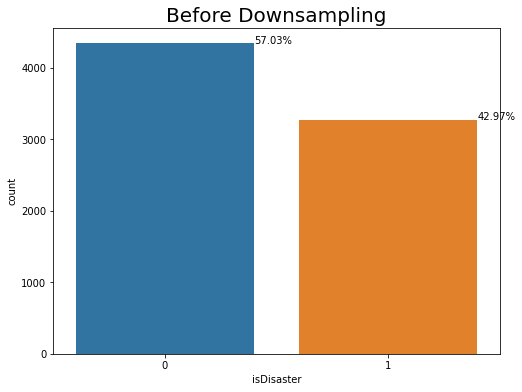

(4342, 3) (3271, 3)


In [ ]:
plt.figure(figsize = (8,6))
cntPlot = sns.countplot(x = 'isDisaster', data = original_tweets)
plt.title('Before Downsampling', fontsize=20)
for p in cntPlot.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(isNotDisaster_tweets)+len(isDisaster_tweets)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    cntPlot.annotate(percentage, (x, y))
plt.show()

print(isNotDisaster_tweets.shape, isDisaster_tweets.shape)

From the graph, we can see that the percentage is far from the ideal `50%`. The number of data in each category is also imbalanced (**4,342** vs **3,271**). We will need to downsample `isDisaster = 0` to produce a balanced  training dataset.

### Downsample Data
---

Using `sample()` function, we can downsample `isDisaster = 0` to match the number of data in `isDisaster = 1`

NOTE: comment out this line if accuracy high for original data

In [ ]:
isNotDisaster_tweets = isNotDisaster_tweets.sample(n = len(isDisaster_tweets))

### Verify downsampling
---


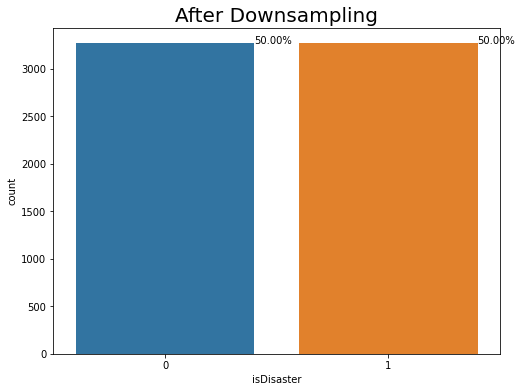

(3271, 3) (3271, 3)


In [ ]:
tweets_concat = pd.concat([isNotDisaster_tweets,isDisaster_tweets]).reset_index(drop=True)
plt.figure(figsize=(8,6))
plt.title('After Downsampling', fontsize=20)
cntPlot = sns.countplot(x=tweets_concat.isDisaster)
for p in cntPlot.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(isNotDisaster_tweets)+len(isDisaster_tweets)))
    x = p.get_x() + (p.get_width())
    y = p.get_height()
    cntPlot.annotate(percentage, (x, y))
plt.show()

print(isNotDisaster_tweets.shape, isDisaster_tweets.shape)

Now we have successfully balanced out the percentage to `50%` and it has matching number of data (**3,271**). We can proceed to visualize the data.